In [1]:
import numpy as np
import pandas as pd
#import geopandas as gpd
#from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
#import descartes
#import pyproj



pd.options.display.max_columns = None

# airbnb

In [2]:
df = pd.read_csv('data/listings.csv', index_col='id')
df.head()

C:\Anaconda\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3647,https://www.airbnb.com/rooms/3647,20190912153101,2019-09-13,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,NaN,NaN,https://a0.muscache.com/im/pictures/838341/9b3...,NaN,4632,https://www.airbnb.com/users/show/4632,Elisabeth,2008-11-25,"New York, New York, United States",Make Up Artist National/ (Website hidden by Ai...,a few days or more,0%,NaN,f,https://a0.muscache.com/im/users/4632/profile_...,https://a0.muscache.com/im/users/4632/profile_...,Harlem,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"New York, NY, United States",Harlem,Harlem,Manhattan,New York,NY,10027,New York,"New York, NY",US,United States,40.80902,-73.94190,t,Apartment,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",NaN,$150.00,NaN,NaN,$200.00,$75.00,2,$20.00,3,7,3,3,7,7,3.0,7.0,37 months ago,t,30,60,90,365,2019-09-13,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
3831,https://www.airbnb.com/rooms/3831,20190912153101,2019-09-13,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,NaN,B52 bus for a 10-minute ride to downtown Brook...,You will have exclusive use of and access to: ...,"We'll be around, but since you have the top fl...",Smoking - outside please; pets allowed but ple...,NaN,NaN,https://a0.muscache.com/im/pictures/e49999c2-9...,NaN,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back bi-coastal actor/professor/attorney.,within an hour,92%,NaN,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn, NY, United States",Brooklyn,Clinton Hill,Brooklyn,Brooklyn,NY,11238,New York,"Brooklyn, NY",US,United States

## Weak

transit-(in not null, treat as good)
interaction-(would need to do text analysis to find the level of interaction)
Name-house rules (proxy for host effort in creating profile. Check word counts, not null and such)
host_location
security_deposit
cleaning_fee
minimum_nights
maximum_nights


## Strong

host_is_superhost
neighbourhood
accommodates
bed_type
bathrooms
bedrooms
room_type
property_type
amenities
number_of_reviews

In [3]:
new_df = df[['host_is_superhost',
'neighbourhood',
'accommodates',
'bed_type',
'bathrooms',
'bedrooms',
'room_type',
'property_type',
'amenities',
'number_of_reviews',
'price']]


In [4]:
new_df['host_is_superhost'][new_df['host_is_superhost']=='f'] = False
new_df['host_is_superhost'][new_df['host_is_superhost']=='t'] = True

C:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda\envs\py36\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Anaconda\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_ob

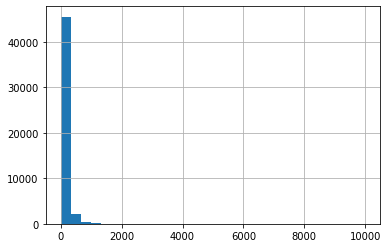

In [5]:
from money_parser import price_dec
df['price'].map(lambda v: float(price_dec(v))).hist(bins=30);

In [6]:
(df['host_location'] == 'New York, New York, United States').value_counts()

True     31537
False    16840
Name: host_location, dtype: int64

In [7]:
#USE PRICE AS THE REGRESSOR AS IT HAS MOST DATA. WEEKLY AND MONTHLY ARE SPARSE
df['price'].isnull().value_counts()

df['weekly_price'].isnull().value_counts()
df['monthly_price'].isnull().value_counts()

True     43376
False     5001
Name: monthly_price, dtype: int64

## Census

In [8]:
census_df = pd.read_csv('data/nyc_census_tracts.csv')
census_blocks_df = pd.read_csv('data/census_block_loc.csv')

In [9]:
census_blocks_df['CensusTract'] = census_blocks_df['BlockCode'].apply(lambda v: int(str(v)[:-4]))
tract_to_coords_df = census_blocks_df.drop('BlockCode', axis='columns').groupby('CensusTract').mean()
census_all_df = tract_to_coords_df.reset_index().merge(census_df, on='CensusTract', how='right')
census_all_df = census_all_df[census_all_df['Latitude'].notnull()]

In [10]:
census_all_df

,CensusTract,Latitude,Longitude,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,40.792756,-73.883541,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,1.6,6476,NaN,NaN,2440.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,40.805866,-73.860278,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,3639,72034.0,13991.0,22180.0,2206.0,20.0,20.7,28.7,17.1,23.9,8.0,22.3,44.8,13.7,38.6,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,40.807594,-73.851237,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,4100,74836.0,8407.0,27700.0,2449.0,13.2,23.6,32.2,23.4,24.9,9.0,10.5,41.3,10.0,44.6,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,40.819196,-73.858040,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,3536,32312.0,6859.0,17526.0,2945.0,26.3,35.9,19.1,36.1,26.2,4.9,13.8,37.2,5.3,45.5,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,40.801216,-73.909212,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,1557,37936.0,3771.0,17986.0,2692.0,37.1,31.5,35.4,20.9,26.2,6.6,11.0,19.2,5.3,63.9,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,36085030302,40.623367,-74.158221,Richmond,Staten Island,6279,3093,3186,35.8,28.7,17.6,0.0,14.3,3842,76542.0,8095.0,25189.0,3131.0,19.0,27.8,35.8,20.6,23.3,8.4,12.0,53.8,8.9,35.1,0.9,0.0,1.3,46.6,2668,74.4,22.5,3.2,0.0,6.2
2148,36085031901,40.630377,-74.163920,Richmond,Staten Island,2550,953,1597,27.1,6.2,60.4,0.0,6.3,1558,25064.0,7879.0,12753.0,2439.0,39.3,51.4,29.7,30.6,21.1,7.3,11.3,38.7,2.4,49.4,9.5,0.0,0.0,38.2,710,73.8,21.8,4.4,0.0,13.8
2149,36085031902,40.639422,-74.166256,Richmond,Staten Island,4611,2043,2568,20.9,14.7,61.9,0.0,0.9,2649,22656.0,8776.0,16303.0,2818.0,41.2,53.8,31.0,37.7,18.1,6.1,7.1,44.9,7.2,44.5,0.5,0.0,2.7,40.9,1308,84.7,12.6,2.7,0.0,9.4
2150,36085032300,40.635312,-74.179497,Richmond,Staten Island,1131,597,534,45.5,24.0,29.7,0.0,0.0,768,56406.0,22600.0,34261.0,10543.0,20.5,16.5,26.2,21.0,34.8,2.8,15.2,53.6,8.8,32.8,4.9,0.0,0.0,52.5,534,65.0,31.1,3.9,0.0,10.7


In [11]:
census_all_df.groupby('CensusTract')[['Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr']].mean()

,Income,IncomeErr,IncomePerCap,IncomePerCapErr
CensusTract,,,,
36005000100,NaN,NaN,2440.0,373.0
36005000200,72034.0,13991.0,22180.0,2206.0
36005000400,74836.0,8407.0,27700.0,2449.0
36005001600,32312.0,6859.0,17526.0,2945.0
36005001900,37936.0,3771.0,17986.0,2692.0
...,...,...,...,...
36085030302,76542.0,8095.0,25189.0,3131.0
36085031901,25064.0,7879.0,12753.0,2439.0
36085031902,22656.0,8776.0,16303.0,2818.0


In [12]:
census_all_df

,CensusTract,Latitude,Longitude,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,40.792756,-73.883541,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,1.6,6476,NaN,NaN,2440.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,40.805866,-73.860278,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,3639,72034.0,13991.0,22180.0,2206.0,20.0,20.7,28.7,17.1,23.9,8.0,22.3,44.8,13.7,38.6,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,40.807594,-73.851237,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,4100,74836.0,8407.0,27700.0,2449.0,13.2,23.6,32.2,23.4,24.9,9.0,10.5,41.3,10.0,44.6,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,40.819196,-73.858040,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,3536,32312.0,6859.0,17526.0,2945.0,26.3,35.9,19.1,36.1,26.2,4.9,13.8,37.2,5.3,45.5,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,40.801216,-73.909212,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,1557,37936.0,3771.0,17986.0,2692.0,37.1,31.5,35.4,20.9,26.2,6.6,11.0,19.2,5.3,63.9,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,36085030302,40.623367,-74.158221,Richmond,Staten Island,6279,3093,3186,35.8,28.7,17.6,0.0,14.3,3842,76542.0,8095.0,25189.0,3131.0,19.0,27.8,35.8,20.6,23.3,8.4,12.0,53.8,8.9,35.1,0.9,0.0,1.3,46.6,2668,74.4,22.5,3.2,0.0,6.2
2148,36085031901,40.630377,-74.163920,Richmond,Staten Island,2550,953,1597,27.1,6.2,60.4,0.0,6.3,1558,25064.0,7879.0,12753.0,2439.0,39.3,51.4,29.7,30.6,21.1,7.3,11.3,38.7,2.4,49.4,9.5,0.0,0.0,38.2,710,73.8,21.8,4.4,0.0,13.8
2149,36085031902,40.639422,-74.166256,Richmond,Staten Island,4611,2043,2568,20.9,14.7,61.9,0.0,0.9,2649,22656.0,8776.0,16303.0,2818.0,41.2,53.8,31.0,37.7,18.1,6.1,7.1,44.9,7.2,44.5,0.5,0.0,2.7,40.9,1308,84.7,12.6,2.7,0.0,9.4
2150,36085032300,40.635312,-74.179497,Richmond,Staten Island,1131,597,534,45.5,24.0,29.7,0.0,0.0,768,56406.0,22600.0,34261.0,10543.0,20.5,16.5,26.2,21.0,34.8,2.8,15.2,53.6,8.8,32.8,4.9,0.0,0.0,52.5,534,65.0,31.1,3.9,0.0,10.7


## Crime

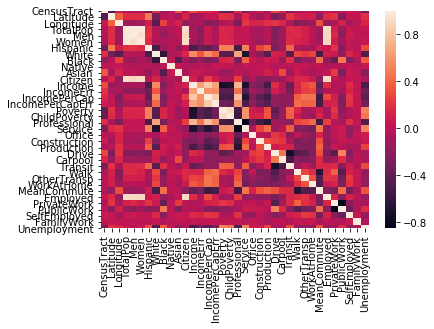

In [13]:
import seaborn as sns
%matplotlib inline

corr = census_all_df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## REGRESS WITH CENSUS & CRIME

In [14]:
from money_parser import price_dec
import lightgbm as lgbm

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, make_scorer

In [16]:
# def curr_to_float(v): return float(price_dec(v)) if v else v
# def tf_to_10(v): return 1 if v == 't' else 0
# def nulls_to_0(v): return float(0 if (pd.isnull(v) or v == '') else v)

# converters_to_columns = [
#     (curr_to_float, ['price', 'weekly_price', 'monthly_price']),
#     (tf_to_10, ['instant_bookable', 'host_is_superhost']),
#     (nulls_to_0, ['bedrooms', 'bathrooms'])
# ]

# converters = {col: conv for conv, cols in converters_to_columns for col in cols}

# df = pd.read_csv('data/listingwithcensus.csv', index_col='id', converters=converters)
# df.rename(columns={"census_tracts": "CensusTract"},inplace= True)

# df.drop(['scrape_id', 'listing_url', 'last_scraped', 'space', 'description', 
#          'picture_url', 'host_url', 'host_thumbnail_url', 'country', 'market', 
#          'host_picture_url'], axis='columns')

# newdf = pd.merge(df, census_all_df, how='left', on='CensusTract').set_index(df['id'])
# #newdf = df.reset_index().merge(census_all_df, how="left").set_index('id')

# ACeCr = pd.merge(newdf, crime_df, on='id')

In [17]:
ACeCr = pd.read_csv('data/old_listings_all.csv', index_col=0)


C:\Anaconda\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
amenities_list = ['Heating', 'Kitchen', 'Air conditioning', 'Hangers', 'Hair dryer', 'Shampoo', 'Iron', 'Laptop friendly workspace',
                  'Hot water', 'Family/kid friendly', 'Coffee maker', 'Extra pillows and blankets', 'Luggage dropoff allowed'
                  ,'No stairs or steps to enter', 'Lock on bedroom door'] 
adjectives = ['private','new','spacious','cozy','great','beautiful','heart','large','quiet','clean','modern','comfortable','perfect','best',
'sunny','renovated','bright','available']

ACeCr['Wifi'] = np.where((ACeCr['amenities'].str.contains('Wifi') | ACeCr['amenities'].str.contains('Internet')),1,0)
ACeCr['TV'] = np.where((ACeCr['amenities'].str.contains('TV') | ACeCr['amenities'].str.contains('Cable TV')),1,0)
ACeCr['Self check-in'] = np.where((ACeCr['amenities'].str.contains('Self check-in') | ACeCr['amenities'].str.contains('24-hour check-in')),1,0)
ACeCr['Free parking'] = np.where((ACeCr['amenities'].str.contains('Free street parking') | ACeCr['amenities'].str.contains('Free parking on premises')),1,0)
ACeCr['Pets allowed'] = np.where((ACeCr['amenities'].str.contains('Pets allowed') | ACeCr['amenities'].str.contains('Cat(s)') | ACeCr['amenities'].str.contains('Dog(s)')),1,0)
ACeCr['Pets on property'] = np.where(ACeCr['amenities'].str.contains('Pets live on this property'),1,0)

for i in amenities_list:
    ACeCr[i] = np.where(ACeCr['amenities'].str.contains(i),1,0)
    
ACeCr['text'] = ACeCr['name'] + ' ' + ACeCr['summary']

for adj in adjectives:
    ACeCr[adj] = np.where(ACeCr['text'].str.contains(adj),1,0)
    
hoods = np.unique(df['neighbourhood_cleansed'].to_numpy())

for hood in hoods:
    ACeCr[hood] = np.where(ACeCr['neighbourhood_cleansed'].str.contains(hood),1,0)

      
ACeCr

C:\Anaconda\envs\py36\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,census_tracts,box_lower_latitude,box_upper_latitude,box_lower_longitude,box_upper_longitude,box,crime_score,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,avg_tract_latitude,avg_tract_longitude,Wifi,TV,Self check-in,Free parking,Pets allowed,Pets on property,Heating,Kitchen,Air conditioning,Hangers,Hair dryer,Shampoo,Iron,Laptop friendly workspace,Hot water,Family/kid friendly,Coffee maker,Extra pillows and blankets,Luggage dropoff allowed,No stairs or steps to enter,Lock on bedroom door,text,private,new,spacious,cozy,great,beautiful,heart,large,quiet,clean,modern,comfortable,perfect,best,sunny,renovated,bright,available,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",Baychester,Bayside,Bayswater,Bedford-Stuyvesant,Belle Harbor,Bellerose,Belmont,Bensonhurst,Bergen Beach,Boerum Hill,Borough Park,Breezy Point,Briarwood,Brighton Beach,Bronxdale,Brooklyn Heights,Brownsville,Bull's Head,Bushwick,Cambria Heights,Canarsie,Carroll Gardens,Castle Hill,Castleton Corners,Charleston,Chelsea,Chinatown,City Island,Civic Center,Claremont Village,Clason Point,Clifton,Clinton Hill,Co-op City,Cobble Hill,College Point,Columbia St,Concord,Concourse,Concourse Village,Coney Island,Corona,Country Club,Crown Heights,Cypress Hills,DUMBO,Ditmars Steinway,Dongan Hills,Douglaston,Downtown Brooklyn,Dyker Heights,East Elmhurst,East Flatbush,East Harlem,East Morrisania,East New York,East Village,Eastchester,Edenwald,Edgemere,Elmhurst,Eltingville,Emerson Hill,Far Rockaway,Fieldston,Financial District,Flatbush,Flatiron District,Flatlands,Flushing,Fordham,Forest Hills,Fort Greene,Fort Hamilton,Fort Wadsworth,Fresh Meadows,Gerritsen Beach,Glendale,Gowanus,Gramercy,Graniteville,Grant City,Gravesend,Great Kills,Greenpoint,Greenwich Village,Grymes Hill,Harlem,Hell's Kitchen,Highbridge,Hollis,Holliswood,Howard Beach,Howland Hook,Huguenot,Hunts Point,Inwood,Jackson Heights,Jamaica,Jamaica Estates,Jamaica Hills,Ke

In [19]:
corr = ACeCr.corr()['number_of_reviews']
corr = corr
corr.sort_values().tail(60)

review_scores_rating           0.035724
Bedford-Stuyvesant             0.036319
ChildPoverty                   0.042030
Lock on bedroom door           0.042355
Poverty                        0.042524
Harlem                         0.042644
Springfield Gardens            0.043192
Construction                   0.044625
Carpool                        0.045339
instant_bookable               0.046457
availability_60                0.048953
review_scores_value            0.050176
Wifi                           0.053471
Production                     0.053510
Elmhurst                       0.054182
Unemployment                   0.055210
beds                           0.056546
box_lower_longitude            0.060213
box_upper_longitude            0.060242
avg_tract_longitude            0.060471
longitude                      0.060769
Drive                          0.065507
PublicWork                     0.067887
private                        0.068148
MeanCommute                    0.068699


In [20]:
corr.sort_values().head(30)

host_id                                       -0.141390
square_feet                                   -0.101288
minimum_minimum_nights                        -0.087576
minimum_nights                                -0.087373
White                                         -0.082807
minimum_nights_avg_ntm                        -0.082471
IncomePerCap                                  -0.079211
maximum_minimum_nights                        -0.071107
Income                                        -0.070901
host_listings_count                           -0.070328
host_total_listings_count                     -0.070328
calculated_host_listings_count                -0.070020
Professional                                  -0.068489
IncomePerCapErr                               -0.067090
calculated_host_listings_count_entire_homes   -0.067002
Kitchen                                       -0.064737
Walk                                          -0.062547
PrivateWork                                   -0

In [21]:
imp_df = ACeCr.copy()
imp_df = imp_df[[
    'accommodates','bathrooms','IncomePerCap','Professional','WorkAtHome','White','Citizen','host_response_rate','price','guests_included'  
    ,'Hair dryer', 'Iron', 'Coffee maker', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Lock on bedroom door','TV'
    ,'private','new','great','heart','comfortable'
    ,'beds','bedrooms','Office','MeanCommute'
    ,'Service','Poverty','Unemployment','Construction','Transit','Production','Black','Hispanic','crime_score'
    ,'room_type','property_type', 'number_of_reviews'
    ,'host_id','latitude','longitude','minimum_nights','reviews_per_month','calculated_host_listings_count','availability_365'
]]
imp_df['host_response_rate'] = imp_df['host_response_rate'].fillna('0%')
imp_df['host_response_rate'] = imp_df['host_response_rate'].map(lambda x: str(x)[:-1])


# imp_df['neighbourhood'], neighbourhood_map = pd.factorize(ACeCr['neighbourhood'])
imp_df['property_type'], property_type_map = pd.factorize(ACeCr['property_type'])
# imp_df['bed_type'], bed_type_map = pd.factorize(ACeCr['bed_type'])
imp_df['room_type'], room_type_map = pd.factorize(ACeCr['room_type'])
# imp_df['zipcode'], zipcode_map = pd.factorize(ACeCr['zipcode'])


In [22]:
popul = ACeCr.copy()
popul = popul[[
    'accommodates','bathrooms','IncomePerCap','Professional','WorkAtHome','White','Citizen','host_response_rate','price','guests_included'  
    ,'Hair dryer', 'Iron', 'Coffee maker', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Lock on bedroom door','TV'
    ,'private','new','great','heart','comfortable'
    ,'beds','bedrooms','Office','MeanCommute'
    ,'Service','Poverty','Unemployment','Construction','Transit','Production','Black','Hispanic','crime_score'
    ,'room_type','property_type', 'number_of_reviews'
    ,'host_id','latitude','longitude','minimum_nights','reviews_per_month','calculated_host_listings_count','availability_365'
,'host_is_superhost'
]]
popul['host_response_rate'] = popul['host_response_rate'].fillna('0%')
popul['host_response_rate'] = popul['host_response_rate'].map(lambda x: str(x)[:-1])


# imp_df['neighbourhood'], neighbourhood_map = pd.factorize(ACeCr['neighbourhood'])
popul['property_type'], property_type_map = pd.factorize(ACeCr['property_type'])
# imp_df['bed_type'], bed_type_map = pd.factorize(ACeCr['bed_type'])
popul['room_type'], room_type_map = pd.factorize(ACeCr['room_type'])
# imp_df['zipcode'], zipcode_map = pd.factorize(ACeCr['zipcode'])

In [23]:
# imp_df['number_of_reviews'].dropna(inplace=True)

In [31]:
X = imp_df.drop('price', axis='columns').values
y = imp_df['price'].values
X1 = popul.drop('number_of_reviews', axis='columns').values
y1= popul['number_of_reviews'].values

const_params = {
    'objective':                      'regression', 
    'metric':                         'rmse',
    'n_jobs':                         -1
}

tuning_parameters = {
    'learning_rate':                  [0.03], 
    'max_depth':                      [20], 
    'n_estimators':                   [300], 
    'random_state':                   [0],
#     'num_leaves':                     [1000]
}

def rmse(y_true, y_pred): return abs(np.sqrt(mean_squared_error(y_true, y_pred)))
scorer = make_scorer(rmse, greater_is_better=False)

grid = GridSearchCV(lgbm.LGBMRegressor(**const_params), 
                    tuning_parameters, 
                    cv=StratifiedKFold(5), 
                    scoring=scorer, 
                    n_jobs=-1)

grid2 = GridSearchCV(lgbm.LGBMRegressor(**const_params), 
                    tuning_parameters, 
                    cv=StratifiedKFold(5), 
                    scoring=scorer, 
                    n_jobs=-1)

grid.fit(X, y)
grid2.fit(X1, y1)

print(f'Best parameters {grid.best_params_}.')
print(f'Best RMSE is {-1*grid.best_score_}.')
print(" ")
print(f'Best parameters {grid2.best_params_}.')
print(f'Best RMSE is {-1*grid2.best_score_}.')

C:\Anaconda\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Anaconda\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from

Best parameters {'learning_rate': 0.03, 'max_depth': 20, 'n_estimators': 300, 'random_state': 0}.
Best RMSE is 156.14279488544886.
 
Best parameters {'learning_rate': 0.03, 'max_depth': 20, 'n_estimators': 300, 'random_state': 0}.
Best RMSE is 31.099092124804493.


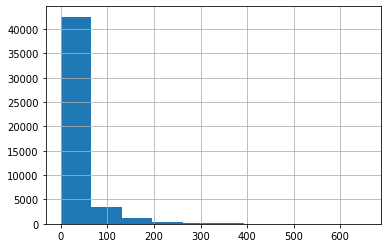

In [25]:
imp_df['number_of_reviews'].hist()

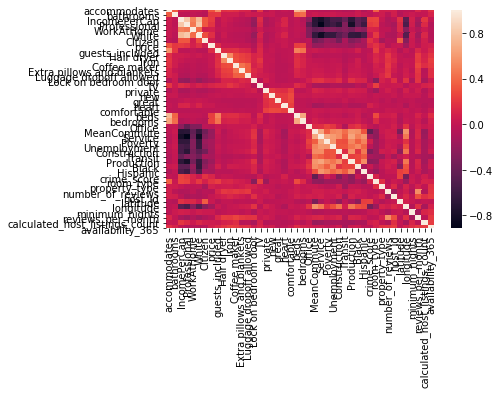

In [26]:
import seaborn as sns
%matplotlib inline

corr = imp_df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

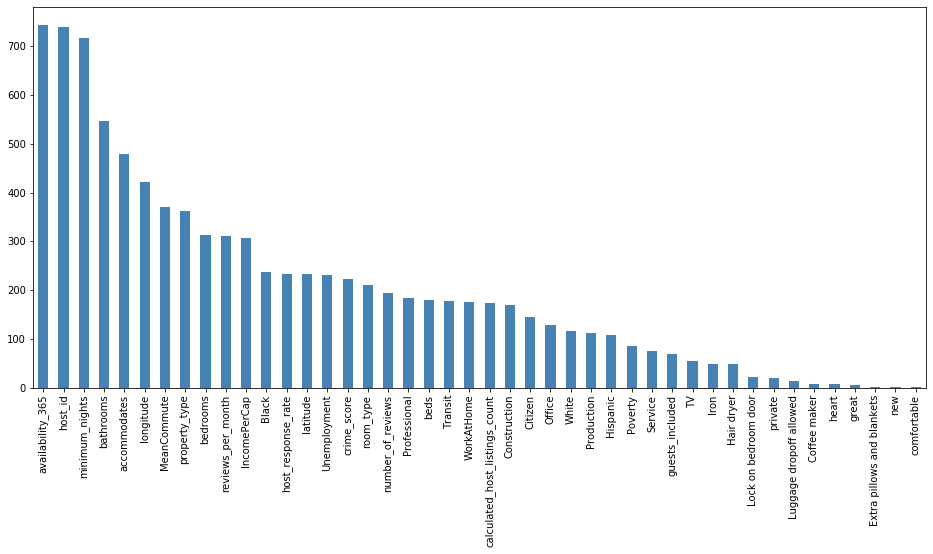

In [27]:
(pd.Series(grid.best_estimator_.feature_importances_, 
           index=imp_df.drop('price', axis='columns').columns.tolist()).sort_values(ascending=False)
 .plot.bar(color='steelblue', figsize=(16, 7)));

In [28]:
imp_df.dropna(inplace=True)
popul.dropna(inplace=True)

In [29]:
import statsmodels.api as sm
X = imp_df.drop('price', axis='columns')
y = imp_df['price']

model_price = sm.OLS(y, X.astype(float)).fit()
model_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     246.5
Date:                Mon, 16 Dec 2019   Prob (F-statistic):               0.00
Time:                        12:18:19   Log-Likelihood:            -2.5147e+05
No. Observations:               38226   AIC:                         5.030e+05
Df Residuals:                   38182   BIC:                         5.034e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
accommodates                      27.6532      0.838     33.001      0.000      26.011      29.296
bathrooms                         53.6192      2.391     22.430      0.000      48.934      58.305
IncomePerCap                       0.0007   5.74e-05     12.264      0.000       0.001       0.001
Professional                     -17.0692     12.609     -1.354      0.176     -41.783       7.644
WorkAtHome                         1.3652      0.325      4.202      0.000       0.728       2.002
White                             -0.4359      0.092     -4.727      0.000      -0.617      -0.255
Citizen                            0.0016      0.001      2.978      0.003       0.001       0.003
host_response_rate                 0.0026      0.025      0.104      0.918      -0.047       0.053
guests_included                    0.9573      0.956      1.002      0.317      -0.916       2.831
Hair dryer                         0.9871      2.329      0.424      0.672      -3.577       5.551
Iron                               0.4839      2.274      0.213      0.831      -3.972       4.940
Coffee maker                       2.1270      2.350      0.905      0.366      -2.480       6.734
Extra pillows and blankets        -2.6888      2.452     -1.097      0.273      -7.495       2.117
Luggage dropoff allowed            4.6871      2.579      1.817      0.069      -0.368       9.743
Lock on bedroom door              -7.6816      2.036     -3.773      0.000     -11.672      -3.691
TV                                10.7513      2.030      5.297      0.000       6.773      14.730
private                            2.6908      2.211      1.217      0.224      -1.643       7.024
new                               -0.8613      2.615     -0.329      0.742      -5.986       4.264
great                             -4.3152      2.504     -1.723      0.085      -9.223       0.593
heart                              6.8232      2.420      2.819      0.005       2.080      11.567
comfortable                        1.4917      2.890      0.516      0.606      -4.172       7.156
beds                              -9.8861      1.282     -7.713      0.000     -12.398      -7.374
bedrooms                          25.3931      1.771     14.340      0.000      21.922      28.864
Office                           -17.0077     12.598     -1.350      0.177     -41.700       7.685
MeanCommute                       -2.7589      0.248    -11.135      0.000      -3.245      -2.273
Service                          -17.4893     12.600     -1.388      0.165     -42.186       7.208
Poverty                            0.2781      0.136      2.045      0.041       0.012       0.545
Unemployment                      -0.0671      0.265     -0.253      0.800      -0.587       0.452
Construction  

In [30]:
import statsmodels.api as sm
X = popul.drop('number_of_reviews', axis='columns')
y = popul['number_of_reviews']

model_price = sm.OLS(y, X.astype(float)).fit()
model_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_of_reviews   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     714.4
Date:                Mon, 16 Dec 2019   Prob (F-statistic):               0.00
Time:                        12:18:19   Log-Likelihood:            -1.9198e+05
No. Observations:               38226   AIC:                         3.840e+05
Df Residuals:                   38181   BIC:                         3.844e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
accommodates                       0.2989      0.179      1.667      0.095      -0.052       0.650
bathrooms                         -2.9540      0.507     -5.823      0.000      -3.948      -1.960
IncomePerCap                   -9.491e-06   1.21e-05     -0.782      0.434   -3.33e-05    1.43e-05
Professional                       0.3402      2.659      0.128      0.898      -4.872       5.552
WorkAtHome                         0.0722      0.069      1.054      0.292      -0.062       0.207
White                             -0.0657      0.019     -3.378      0.001      -0.104      -0.028
Citizen                         1.111e-05      0.000      0.098      0.922      -0.000       0.000
host_response_rate                 0.0005      0.005      0.086      0.931      -0.010       0.011
price                             -0.0061      0.001     -5.641      0.000      -0.008      -0.004
guests_included                    1.3612      0.201      6.756      0.000       0.966       1.756
Hair dryer                         4.1488      0.491      8.448      0.000       3.186       5.111
Iron                               2.2124      0.479      4.614      0.000       1.273       3.152
Coffee maker                       1.1818      0.497      2.376      0.018       0.207       2.157
Extra pillows and blankets        -0.5271      0.518     -1.018      0.308      -1.542       0.487
Luggage dropoff allowed            7.2129      0.544     13.267      0.000       6.147       8.279
Lock on bedroom door              -6.4257      0.428    -15.007      0.000      -7.265      -5.586
TV                                 0.3062      0.428      0.715      0.475      -0.534       1.146
private                            1.6732      0.466      3.588      0.000       0.759       2.587
new                               -2.2594      0.551     -4.098      0.000      -3.340      -1.179
great                              0.7882      0.528      1.493      0.136      -0.247       1.823
heart                             -1.1985      0.511     -2.347      0.019      -2.199      -0.198
comfortable                        2.3565      0.609      3.867      0.000       1.162       3.551
beds                               0.2913      0.271      1.077      0.282      -0.239       0.822
bedrooms                          -1.4687      0.374     -3.923      0.000      -2.203      -0.735
Office                             0.2113      2.657      0.080      0.937      -4.996       5.419
MeanCommute                       -0.1984      0.052     -3.791      0.000      -0.301      -0.096
Service                            0.3091      2.657      0.116      0.907      -4.900       5.518
Poverty                            0.0123      0.029      0.428      0.668      -0.044       0.069
Unemployment  

## Rat sightings